# Clase Práctica 5: Deep learning

Deep learning es un tipo de aprendizaje de máquinas en donde las predicciones se realizan a través de una serie de operaciones matriciales concatenadas. Uno de los elementos más importantes en el Deep Learning es la casi nula ingeniería de características. En el ejemplo que veremos ahora, se utiliza un conjunto de imágenes segmentadas para realizar el entrenamiento de un modelo de segmentación automática de núcleos celulares, este entrenamiento simplemente se realiza con los pixeles crudos de las imágenes, sin ingeniería de características.


In [1]:
import tensorflow as tf # Biblioteca de redes neuronales
import pandas as pd # # Biblioteca de manejo de conjuntos de datos
import sklearn.preprocessing # Preprocesamiento de datos
import sklearn.model_selection # # Funciones para preparar nuestro conjunto de datos
import sklearn.metrics # Métricas
import matplotlib.pyplot as plt # Biblioteca de visualización
import numpy as np # Biblioteca de álgebra lineal
import scipy.stats
import os
import PIL
import datetime

## Red fully connected

Utilizaremos un conjunto de datos que relaciones características fisiológicas extraídas a través de un dispositivo vestible con tipos de actividades que los sujetos estaban realizando en ese momento.

El conjunto de datos es del artículo Activity Recognition Using Wearable Physiological Measurements: Selection of Features from a Comprehensive Literature Study https://pubmed.ncbi.nlm.nih.gov/31847261/

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/fvillena/patrones/main/data/activity_recognition.csv")

In [3]:
data.head()

ecg_original_mean  ecg_original_std  ecg_original_trimmean25  \
0           0.022200          0.278189                 0.047467   
1          -0.001098          0.210017                -0.048560   
2           0.004552          0.148971                -0.004151   
3          -0.005813          0.206158                 0.005190   
4           0.000940          0.073076                -0.008041   

   ecg_original_median  ecg_original_skewness  ecg_original_kurtosis  \
0             0.067892              -0.734477                3.62217   
1            -0.090702               2.137990                8.33018   
2             0.014918               0.400160                2.78112   
3             0.001100              -0.643985                4.62722   
4            -0.012362               1.275040                5.41514   

   ecg_original_max  ecg_original_min  ecg_original_prctile25  \
0          0.838892         -1.442110               -0.136108   
1          1.244300         -0.290702               -0.127702   
2          0.516918         -0.386082               -0.126082   
3          0.549100         -1.126900               -0.116900   
4          0.400638         -0.147362               -0.047362   

   ecg_original_prctile75  ...  eda_functionals_power_filt2kurtosis_1  \
0                0.220892  ...                                1015.81   
1                0.048299  ...                                1016.41   
2                0.100918  ...                                1015.65   
3                0.131100  ...                                1015.62   
4                0.033638  ...                                1015.65   

   eda_functionals_power_filt2max_1  eda_functionals_power_filt2min_1  \
0                       585451000.0                          0.006724   
1                       791163000.0                          0.014209   
2                        76208300.0                          0.003753   
3                       184945000.0                          0.005781   
4                       374871000.0                          0.007874   

   eda_functionals_power_filt2prctile25_1  \
0                                 2.43873   
1                                 4.13302   
2                                 1.25774   
3                                 1.96623   
4                                 2.58581   

   eda_functionals_power_filt2prctile75_1  \
0                                15.87360   
1                                25.89920   
2                                 8.42661   
3                                12.63830   
4                                16.30720   

   eda_functionals_power_filt2geomean(abs)_1  \
0                                    7.39725   
1                                   12.76960   
2                                    4.03412   
3                                    6.26733   
4                                    7.85350   

   eda_functionals_power_filt2harmmean_1  eda_functionals_power_filt2mad_1  \
0                               1.264500                         1152950.0   
1                               2.771000                         1556760.0   
2                               0.753581                          150121.0   
3                               1.331560                          364353.0   
4                               1.638010                          738448.0   

   eda_functionals_power_filt2baseline_1   activity  
0                               601642.0    neutral  
1                               455372.0     mental  
2                                76244.4     mental  
3                              2322520.0  emotional  
4                              2142830.0    neutral  

[5 rows x 534 columns]

El conjunto de datos cuenta con **533 características** de mediciones de Electrocardiograma (ECG), Bioimpedancia Eléctrica Torácica (TEB) y la Actividad Ectodérmica (EDA) for activity recognition.

Las actividades etiquetadas a cada punto de datos son Neutral, Emocional, Mental y Física

In [4]:
features = data.iloc[:,:-1]

label = data.activity

Escalamos nuestras características utilizando un Min-Max Scaler.

In [5]:
scaler = sklearn.preprocessing.MinMaxScaler()
features_scaled = scaler.fit_transform(features)

Nuestras etiquetas son discretas, por lo que las transformamos con un codificador One-Hot

In [6]:
encoder = sklearn.preprocessing.LabelEncoder() # Label encoder de sklearn que mapea las categorías a números enteros
label_encoded = encoder.fit_transform(label)
label_encoded = tf.keras.utils.to_categorical(label_encoded) # Implementación de Tensorflow del One-Hot Encoding

In [7]:
label_encoded

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)

Separamos el conjunto de datos en un subconjunto de entrenamiento, validación y prueba.

In [8]:
features_train, features_test, label_train, label_test = sklearn.model_selection.train_test_split(
    features_scaled,
    label_encoded,
    random_state=11
)
features_train, features_val, label_train, label_val = sklearn.model_selection.train_test_split(
    features_train,
    label_train,
    test_size=0.1,
    random_state=11
)

In [9]:
features_train.shape

(3024, 533)

Diseñamos la arquitectura de nuestra red neuronal.

In [10]:
model = tf.keras.Sequential([ # Este objeto recibe una lista de capas.
    tf.keras.layers.Dense(128, activation='relu'), # Capa densa de 128 neuronas con una activación ReLU
    tf.keras.layers.Dense(len(encoder.classes_), activation='softmax') # Capa densa de clasificación
                                                                       # con una activación Softmax
                                                                       # la cantidad de neuronas de esta capa
                                                                       # debe ser igual a la cantidad de clases
])

Configuramos el modelo para el entrenamiento

In [11]:
model.compile(optimizer='adam', # Utilizamos un optimizador ADAM
              loss='categorical_crossentropy', # Usamos entropía cruzada categórica porque nuestro problema es de clasificación de más de 2 clases
              metrics=['accuracy']) # Medimos el rendimiento del modelo con la exactitud

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping( # Instanciamos un objeto de Early Stopping para detener el entrenamiento si no seguimos aprendiendo
    monitor='val_accuracy', # Monitoreamos el accuracy del conjunto de validación
    patience=3, # Si por 3 épocas seguidas no aumentamos el accuracy, detenemos el entrenamiento
    restore_best_weights=True, # Cuando detenemos el entrenamiento restablecemos los pesos con el mejor rendimiento.
    verbose=True
)

Ajustamos el modelo

In [13]:
history = model.fit( # Guardamos el historial del modelo
          features_scaled,
          label_encoded,
          epochs=10, # Detenemos el entrenamiento al llegar a 10 épocas
          callbacks=[early_stopping], # Llamamos a nuestro objeto de Early Stopping al final de cada época
          validation_data=(features_val,label_val) # Al final de cada época probamos el rendimiento en el conjunto de validación
          )

Epoch 1/10
140/140 [==============================] - 5s 9ms/step - loss: 0.7854 - accuracy: 0.6621 - val_loss: 0.5658 - val_accuracy: 0.7589
Epoch 2/10
140/140 [==============================] - 1s 6ms/step - loss: 0.5545 - accuracy: 0.7464 - val_loss: 0.5337 - val_accuracy: 0.7530
Epoch 3/10
140/140 [==============================] - 1s 6ms/step - loss: 0.5103 - accuracy: 0.7636 - val_loss: 0.4800 - val_accuracy: 0.7798
Epoch 4/10
140/140 [==============================] - 1s 6ms/step - loss: 0.4723 - accuracy: 0.7877 - val_loss: 0.4495 - val_accuracy: 0.7827
Epoch 5/10
140/140 [==============================] - 1s 6ms/step - loss: 0.4440 - accuracy: 0.8009 - val_loss: 0.4424 - val_accuracy: 0.7976
Epoch 6/10
140/140 [==============================] - 1s 6ms/step - loss: 0.4297 - accuracy: 0.8029 - val_loss: 0.4039 - val_accuracy: 0.8155
Epoch 7/10
140/140 [==============================] - 1s 6ms/step - loss: 0.4160 - accuracy: 0.8087 - val_loss: 0.4159 - val_accuracy: 0.7857
Epoch 

Visualizamos el rendimiento de nuestro modelo al avanzar las épocas.

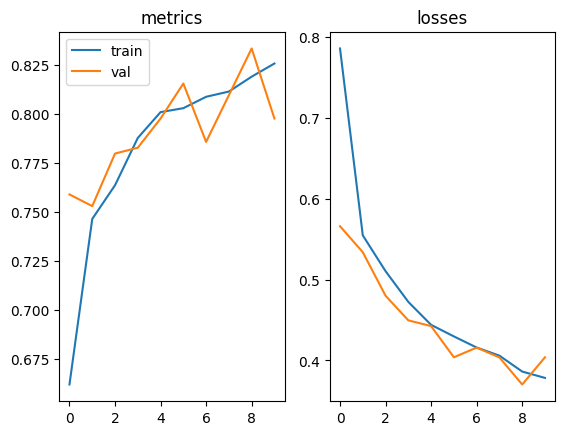

In [14]:
fig, axs = plt.subplots(1,2)
axs[0].plot(
    history.history["accuracy"],
    label="train"
)
axs[0].plot(
    history.history["val_accuracy"],
    label="val"
)
axs[0].set_title("metrics")
axs[1].plot(
    history.history["loss"]
)
axs[1].plot(
    history.history["val_loss"]
)
axs[1].set_title("losses")
axs[0].legend()

Verificamos el rendimiento en el conjunto de prueba

In [15]:
predictions = model.predict(features_test)

35/35 [==============================] - 0s 2ms/step


In [16]:
print(sklearn.metrics.classification_report(
    label_test.argmax(axis=1), # Utilizamos argmax para obtener la etiqueta de cada punto de datos
    predictions.argmax(axis=1)
))

              precision    recall  f1-score   support

           0       0.74      0.66      0.70       267
           1       0.67      0.82      0.74       292
           2       0.97      0.88      0.92       297
           3       1.00      0.98      0.99       264

    accuracy                           0.83      1120
   macro avg       0.85      0.83      0.84      1120
weighted avg       0.85      0.83      0.84      1120



### ¿Que podriamos hacer en este caso para ver si mejoran los resultados?

Aumenta la cantidad de épocas y ver cómo se comportan las métricas al aumentar la cantidad de épocas.

## Red convolucional

Exploraremos cómo se realizan las transformaciones de los datos al transitar por una red convolucional.

In [17]:
def nice_image_printer(model, image):
    """prints the cat as a 2d array"""
    image_batch = np.expand_dims(image,axis=0)
    conv_image2 = model.predict(image_batch)

    conv_image2 = np.squeeze(conv_image2, axis=0)
    conv_image2 = conv_image2.reshape(conv_image2.shape[:2])

    plt.imshow(conv_image2)
    plt.colorbar()

def gkern(kernlen=[21,21], nsig=[3, 3]):
    """Returns a 2D Gaussian kernel array."""

    assert len(nsig) == 2
    assert len(kernlen) == 2
    kern1d = []
    for i in range(2):
        interval = (2*nsig[i]+1.)/(kernlen[i])
        x = np.linspace(-nsig[i]-interval/2., nsig[i]+interval/2., kernlen[i]+1)
        kern1d.append(np.diff(scipy.stats.norm.cdf(x)))

    kernel_raw = np.sqrt(np.outer(kern1d[0], kern1d[1]))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

def kernel_init(shape, dtype=None, partition_info=None):
    """Kernel initializer"""
    kernel = np.zeros(shape)
    kernel[:,:,0,0] = gkern([shape[0], shape[1]])
    return kernel

Cargamos y preprocesamos nuestro conjunto de datos.

In [18]:
!wget https://raw.githubusercontent.com/fvillena/patrones/main/data/cat.png

--2024-01-02 02:44:57--  https://raw.githubusercontent.com/fvillena/patrones/main/data/cat.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 291073 (284K) [image/png]
Saving to: ‘cat.png’

cat.png             100%[===================>] 284.25K  --.-KB/s    in 0.004s  

2024-01-02 02:44:58 (71.6 MB/s) - ‘cat.png’ saved [291073/291073]



In [19]:
cat = tf.keras.preprocessing.image.load_img("cat.png") # Importamos la imagen
cat # Visualizamos la imagen

In [20]:
cat_array = tf.keras.preprocessing.image.img_to_array(cat) / 255 # Transformamos la imagen en un arreglo y lo normalizamos entre 0 y 1.

In [21]:
cat_array.shape # Estas son las dimensiones de nuestra imagen (largo, ancho, canales)

(479, 479, 3)

Instanciamos nuestro primer modelo con una capa única de convolución.

1/1 [==============================] - 1s 919ms/step


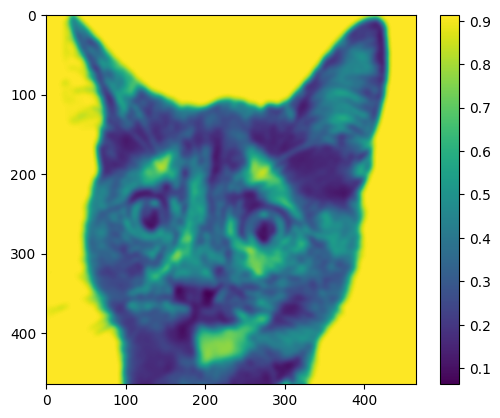

In [22]:
cat_model_1 = tf.keras.Sequential([
  tf.keras.layers.Conv2D( # Capa convolucional
      filters = 1, # Sólo utilizaremos 1 kernel
      kernel_size = (15,15), # Estas son las dimensiones del kernel
      input_shape = cat_array.shape, # Estas son las dimensiones de entrada de la red.
      kernel_initializer = kernel_init # Utilizamos un kernel gausiano que lo generamos con nuestro inicializador
  )
])
nice_image_printer(cat_model_1, cat_array)

Aumentamos el tamaño del kernel.

1/1 [==============================] - 1s 792ms/step


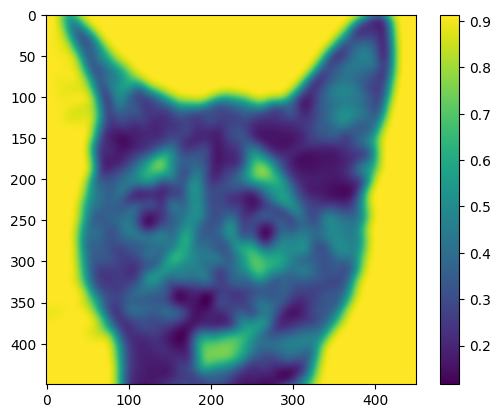

In [23]:
cat_model_2 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(
      filters = 1,
      kernel_size = (30,30), # Ahora el kernel es de 30*30
      input_shape = cat_array.shape,
      kernel_initializer = kernel_init
  )
])
nice_image_printer(cat_model_2, cat_array)

Agregamos una función de activación sigmoidea. Nótese que cambió el rango de los valores (mirar la  barra de color).

In [24]:
cat_model_3 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(
      filters = 1,
      kernel_size = (15,15),
      input_shape = cat_array.shape,
      activation="sigmoid", # Agregamos la función de activación.
      kernel_initializer = kernel_init
  ),
])
nice_image_printer(cat_model_3, cat_array)

1/1 [==============================] - 0s 180ms/step


Agregamos una capa de Max Pooling.

1/1 [==============================] - 0s 151ms/step


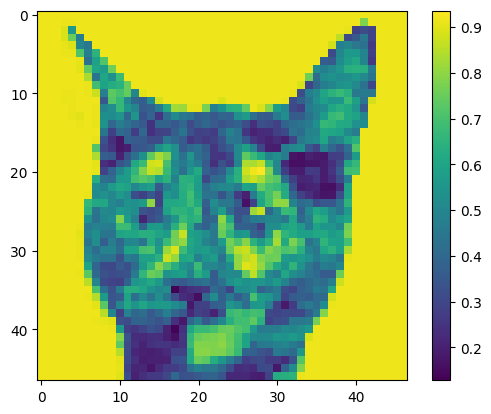

In [25]:
cat_model_4 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(
      filters = 1,
      kernel_size = (3,3),
      input_shape = cat_array.shape,
      kernel_initializer = kernel_init
  ),
  tf.keras.layers.MaxPool2D( # capa de max pooling
      pool_size = (10,10) # Este es el tamaño del max pooling.
  )
])
nice_image_printer(cat_model_4, cat_array)

Agregamos una función de activación y max pooling.

1/1 [==============================] - 0s 58ms/step


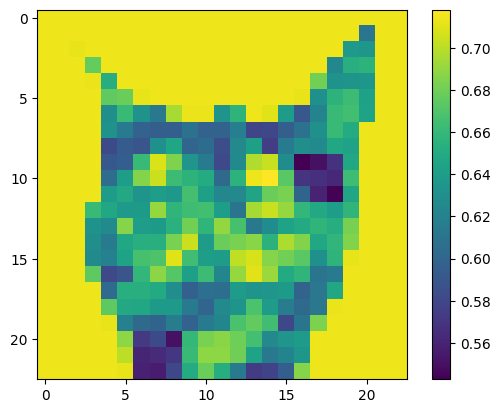

In [26]:
cat_model_5 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(
      filters = 1,
      kernel_size = (3,3),
      input_shape = cat_array.shape,
      activation = "sigmoid",
      kernel_initializer = kernel_init
  ),
  tf.keras.layers.MaxPool2D(
      pool_size = (20,20)
  )
])
nice_image_printer(cat_model_5, cat_array)

Generamos un modelo con múltiples capas de convolución, max pooling y funciones de activación.

1/1 [==============================] - 0s 244ms/step


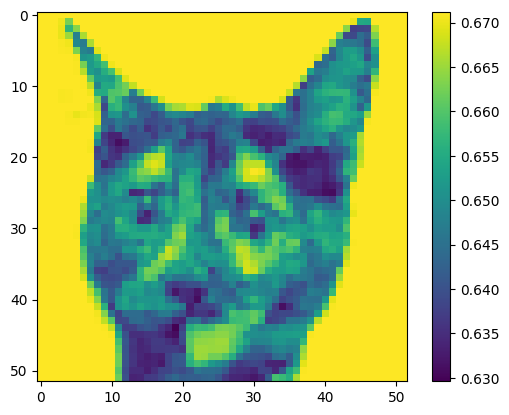

In [27]:
cat_model_6 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(
      filters = 1,
      kernel_size = (3,3),
      input_shape = cat_array.shape,
      activation = "sigmoid",
      kernel_initializer = kernel_init
  ),
  tf.keras.layers.MaxPool2D(
      pool_size = (3,3)
  ),
  tf.keras.layers.Conv2D(
      filters = 1,
      kernel_size = (3,3),
      input_shape = cat_array.shape,
      activation = "sigmoid",
      kernel_initializer = kernel_init
  ),
  tf.keras.layers.MaxPool2D(
      pool_size = (3,3)
  )
])
nice_image_printer(cat_model_6, cat_array)

## Clasificación de radiografías de tórax

Para este notebook se utilizaron los datos de https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5 y código de https://www.kaggle.com/sanwal092/intro-to-cnn-using-keras-to-predict-pneumonia

In [28]:
# Obtenemos el conjunto de datos.
!wget --no-check-certificate "https://users.dcc.uchile.cl/~fvillena/files/chest_xray.zip" -O chest_xray.zip

--2024-01-02 02:45:04--  https://users.dcc.uchile.cl/~fvillena/files/chest_xray.zip
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 200.9.99.211, 192.80.24.4
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|200.9.99.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225631155 (1.1G) [application/zip]
Saving to: ‘chest_xray.zip’

chest_xray.zip      100%[===================>]   1.14G  4.84MB/s    in 4m 7s   

2024-01-02 02:49:12 (4.73 MB/s) - ‘chest_xray.zip’ saved [1225631155/1225631155]



In [29]:
# Descomprimimos el conjunto de datos.
!unzip -q 'chest_xray.zip' -d chest_xray/

In [30]:
# Configuramos las rutas de los datos
train_folder= 'chest_xray/train/'
val_folder = 'chest_xray/val/'
test_folder = 'chest_xray/test/'
train_n = train_folder+'NORMAL/'
train_p = train_folder+'PNEUMONIA/'

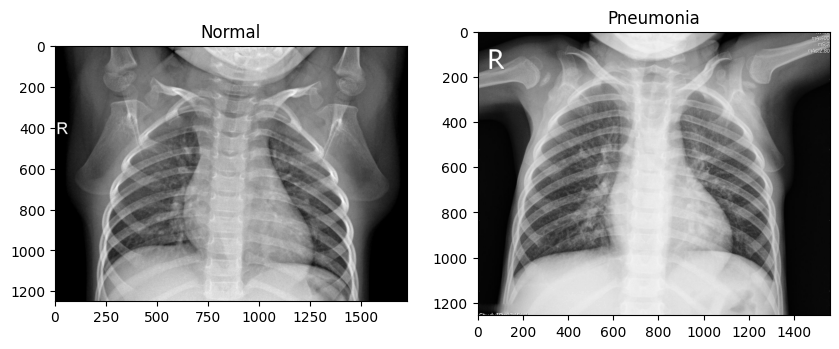

In [31]:
# Miramos un par de radiografías normales y patólogicas al azar

rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]

norm_pic_address = train_n+norm_pic

rand_p = np.random.randint(0,len(os.listdir(train_p)))

sic_pic =  os.listdir(train_p)[rand_norm]
sic_address = train_p+sic_pic

norm_load = PIL.Image.open(norm_pic_address)
sic_load = PIL.Image.open(sic_address)

f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load, cmap="gray")
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_load, cmap="gray")
a2.set_title('Pneumonia')

plt.show()

In [32]:
# Configuramos el generador de datos que utilizará nuestra red

batch_size = 32

# Queremos aumentar los datos del conjunto de prueba al generar imágenes sintéticas distorisionadas
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, # A las imágenes se les normaliza el brillo
                                   shear_range = 0.2, # Distorsionamos las imágenes
                                   zoom_range = 0.2, # Acercamos las imágenes
                                   horizontal_flip = True) # Volteamos horizontalmente las imágenes

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size = (64, 64), # Las imágenes se redimensionan a 64*64
                                                 batch_size = batch_size,
                                                 class_mode = 'binary',
                                                 color_mode="grayscale") # Sólo utilizamos el canal de brillo

val_set = test_datagen.flow_from_directory(val_folder,
                                            target_size=(64, 64),
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            shuffle = False,
                                            color_mode="grayscale")

test_set = test_datagen.flow_from_directory(test_folder,
                                            target_size = (64, 64),
                                            batch_size = batch_size,
                                            class_mode = 'binary',
                                            shuffle = False,
                                            color_mode="grayscale")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [33]:
# Construimos la arquitectura de la red neuronal

cnn = tf.keras.Sequential()

cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 1))) # Capa de convolución

cnn.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu"))

cnn.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(activation = 'relu', units = 128))
cnn.add(tf.keras.layers.Dense(activation = 'sigmoid', units = 1))

cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) # Creamos la arquitectura

In [34]:
# Verificamos la arquitectura

cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [35]:
early_stopping = tf.keras.callbacks.EarlyStopping( # Instanciamos un objeto de Early Stopping para detener el entrenamiento si no seguimos aprendiendo
    monitor='val_accuracy', # Monitoreamos el accuracy del conjunto de validación
    patience=3, # Si por 3 épocas seguidas no aumentamos el accuracy, detenemos el entrenamiento
    restore_best_weights=True, # Cuando detenemos el entrenamiento restablecemos los pesos con el mejor rendimiento.
    verbose=True
)

In [36]:
# Entrenamos la red neuronal

cnn_history = cnn.fit(training_set,
                         epochs = 10, # Entrenamos la red por 10 épocas
                         callbacks=[early_stopping], # Llamamos a nuestro objeto de Early Stopping al final de cada época
                         validation_data = val_set)

Epoch 1/10
163/163 [==============================] - 43s 238ms/step - loss: 0.3778 - accuracy: 0.8319 - val_loss: 0.3394 - val_accuracy: 0.8125
Epoch 2/10
163/163 [==============================] - 34s 207ms/step - loss: 0.2588 - accuracy: 0.8930 - val_loss: 0.6078 - val_accuracy: 0.6875
Epoch 3/10
163/163 [==============================] - 35s 214ms/step - loss: 0.2103 - accuracy: 0.9143 - val_loss: 0.7271 - val_accuracy: 0.6875
Epoch 4/10
163/163 [==============================] - 34s 206ms/step - loss: 0.1883 - accuracy: 0.9248 - val_loss: 0.2350 - val_accuracy: 1.0000
Epoch 5/10
163/163 [==============================] - 34s 206ms/step - loss: 0.1803 - accuracy: 0.9316 - val_loss: 1.1174 - val_accuracy: 0.5625
Epoch 6/10
163/163 [==============================] - 34s 208ms/step - loss: 0.1724 - accuracy: 0.9344 - val_loss: 1.1603 - val_accuracy: 0.5625
Epoch 7/10
163/163 [==============================] - 34s 210ms/step - loss: 0.1622 - accuracy: 0.9381 - val_loss: 0.5466 - val_ac

In [37]:
predictions = cnn.predict(test_set, verbose = 1) > 0.5 # Predecimos sobre el conjunto de prueba

20/20 [==============================] - 3s 122ms/step


In [38]:
sklearn.metrics.confusion_matrix(test_set.classes, predictions) # Matriz de confusión

array([[189,  45],
       [ 26, 364]])

In [39]:
print(sklearn.metrics.classification_report(test_set.classes, predictions)) # Resumen del rendimiento del modelo

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       234
           1       0.89      0.93      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



### Exploración

Para entender cómo funciona la red neuronal, visualizaremos las salidas de cada una de las capas.

In [40]:
def image_loader(path):
  image_location = path # Seleccionamos una imagen del conjunto de prueba
  img = PIL.Image.open(image_location)
  # Cargamos la imagen
  img_resized = tf.keras.preprocessing.image.load_img(
      image_location,
      target_size = (64, 64), # Debemos redimensionar la imagen para poder ser ingresada a la red
      color_mode="grayscale"
  )
  # Transformamos la imagen en un arreglo de las dimensiones que recibe la red
  img_array = tf.keras.preprocessing.image.img_to_array(
      img_resized
  )
  img_array = np.expand_dims(
      img_array,
      axis=0
  )
  return img, img_resized, img_array

def get_activations(model,img_array):
  # Creamos un modelo que entrega los resultados después de cada capa
  layer_outputs = [layer.output for layer in model.layers]
  layer_names = [layer.name for layer in model.layers]
  activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
  activations = activation_model.predict(img_array)
  activations = list(zip(layer_names,activations))
  return activations

# Esta función grafica los resultados de los filtros de la capa de convolución
def plot_conv_layer_result(activations,j):
  fig, axs = plt.subplots(
      nrows=4,
      ncols=8,
      figsize=(15,8)
  )
  fig.suptitle(activations[j][0])
  for i,ax in enumerate(axs.ravel()):
      ax.imshow(activations[j][1][0,:,:,i], cmap="viridis")
      ax.axis("off")
  plt.show()

# Con esto graficamos los arreglos unidimensionales
def plot_1d_layer_result(activations,j):
  values = activations[j][1][0,:]
  plt.bar(
      range(len(values)),
      values
  )
  plt.title(activations[j][0])
  plt.show()

#### Radiografía de pneumonia

In [41]:
pneumonia_img, pneumonia_img_resized, pneumonia_img_array = image_loader("chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg")

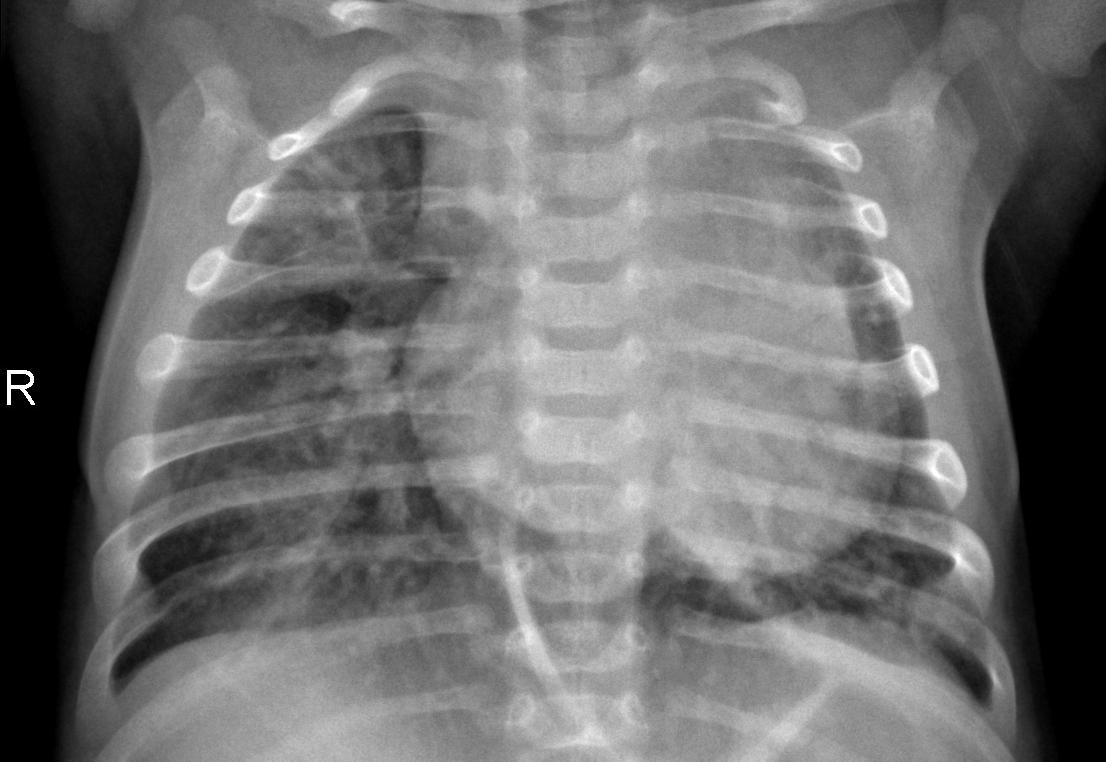

In [42]:
pneumonia_img # Asi se ve la imagen original

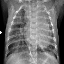

In [43]:
pneumonia_img_resized # Esta es la imagen con las dimensiones correctas para ingresarla a la red

In [44]:
pneumonia_img_array.shape # Esta es la dimensión del arreglo numérico que se ingresará a la red

(1, 64, 64, 1)

In [45]:
# Predecimos sobre el arreglo
cnn.predict(pneumonia_img_array)

1/1 [==============================] - 0s 152ms/step


array([[1.]], dtype=float32)

In [46]:
pneumonia_activations = get_activations(cnn,pneumonia_img_array)

1/1 [==============================] - 0s 115ms/step


En el siguiente gráfico vemos las 32 imágenes correspondientes a la salida de cada uno de los filtros de la capa de convolución.

In [47]:
plot_conv_layer_result(pneumonia_activations,0)

En el siguiente gráfico observamos como la capa de max-pooling reduce la resolución de la imagen.

In [48]:
plot_conv_layer_result(pneumonia_activations,1)

In [49]:
plot_conv_layer_result(pneumonia_activations,2)

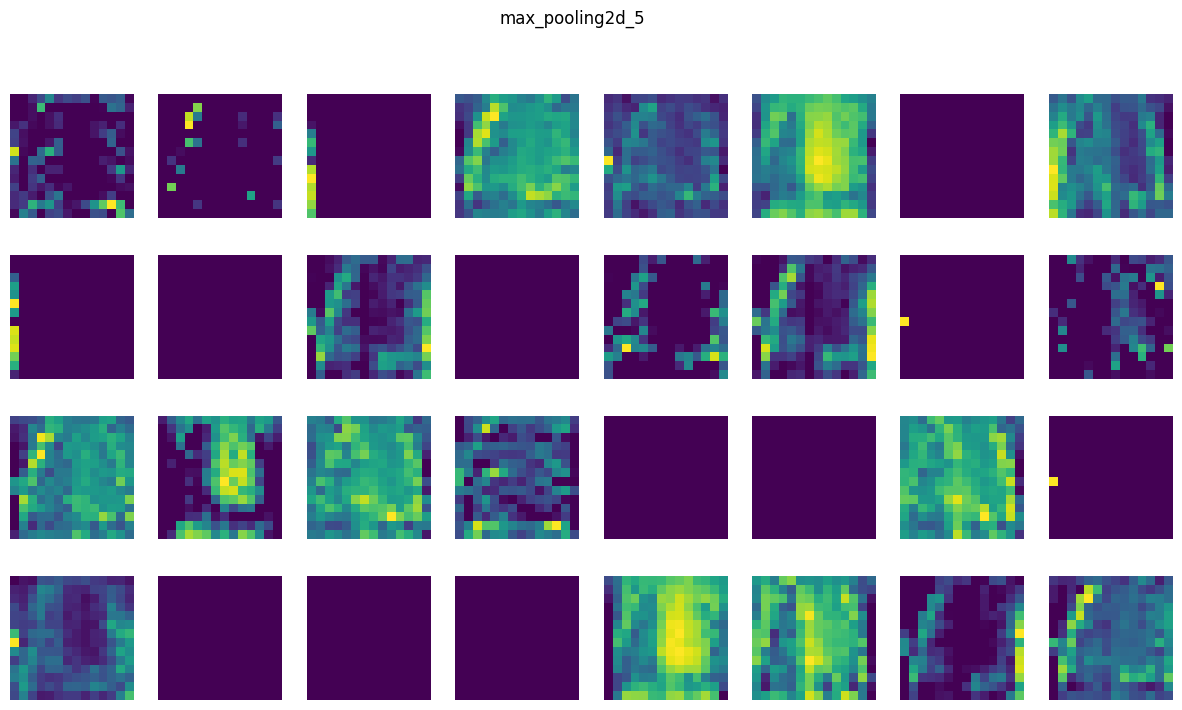

In [50]:
plot_conv_layer_result(pneumonia_activations,3)

Después del segundo max-pooling tenemos sólo arreglos unidimensionales, este primer resultado son todos los elementos del resultado anterior concatenados en un sólo arreglo.

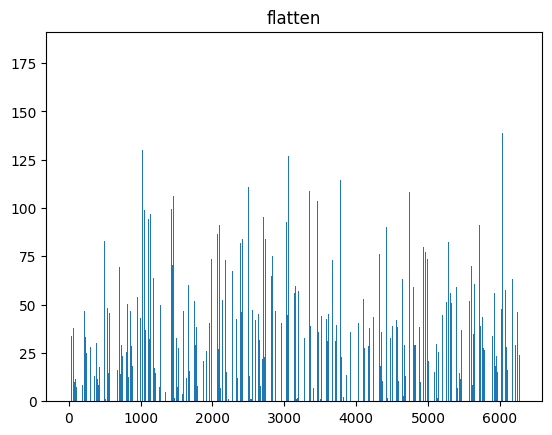

In [51]:
plot_1d_layer_result(pneumonia_activations,4)

Con la capa densa reducimos el número de elementos del arreglo anterior.

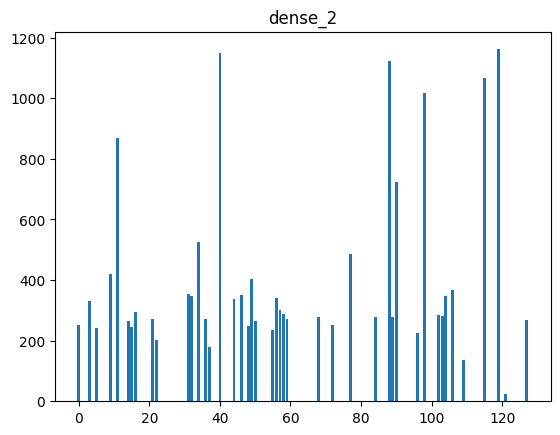

In [52]:
plot_1d_layer_result(pneumonia_activations,5)

La última capa tiene sólo 1 neurona correspondiente a la clasificación final de la red

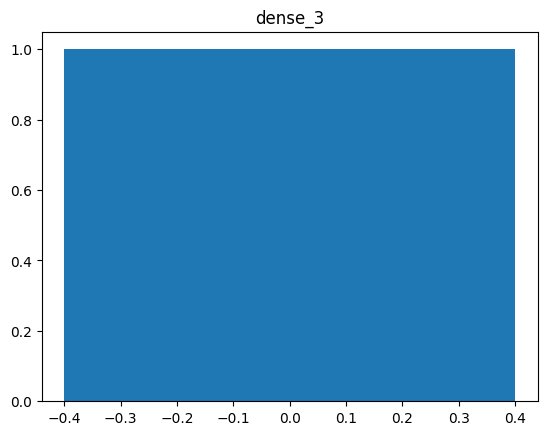

In [53]:
plot_1d_layer_result(pneumonia_activations,6)

#### Radiografía normal

In [54]:
normal_img, normal_img_resized, normal_img_array = image_loader("chest_xray/test/NORMAL/IM-0001-0001.jpeg")

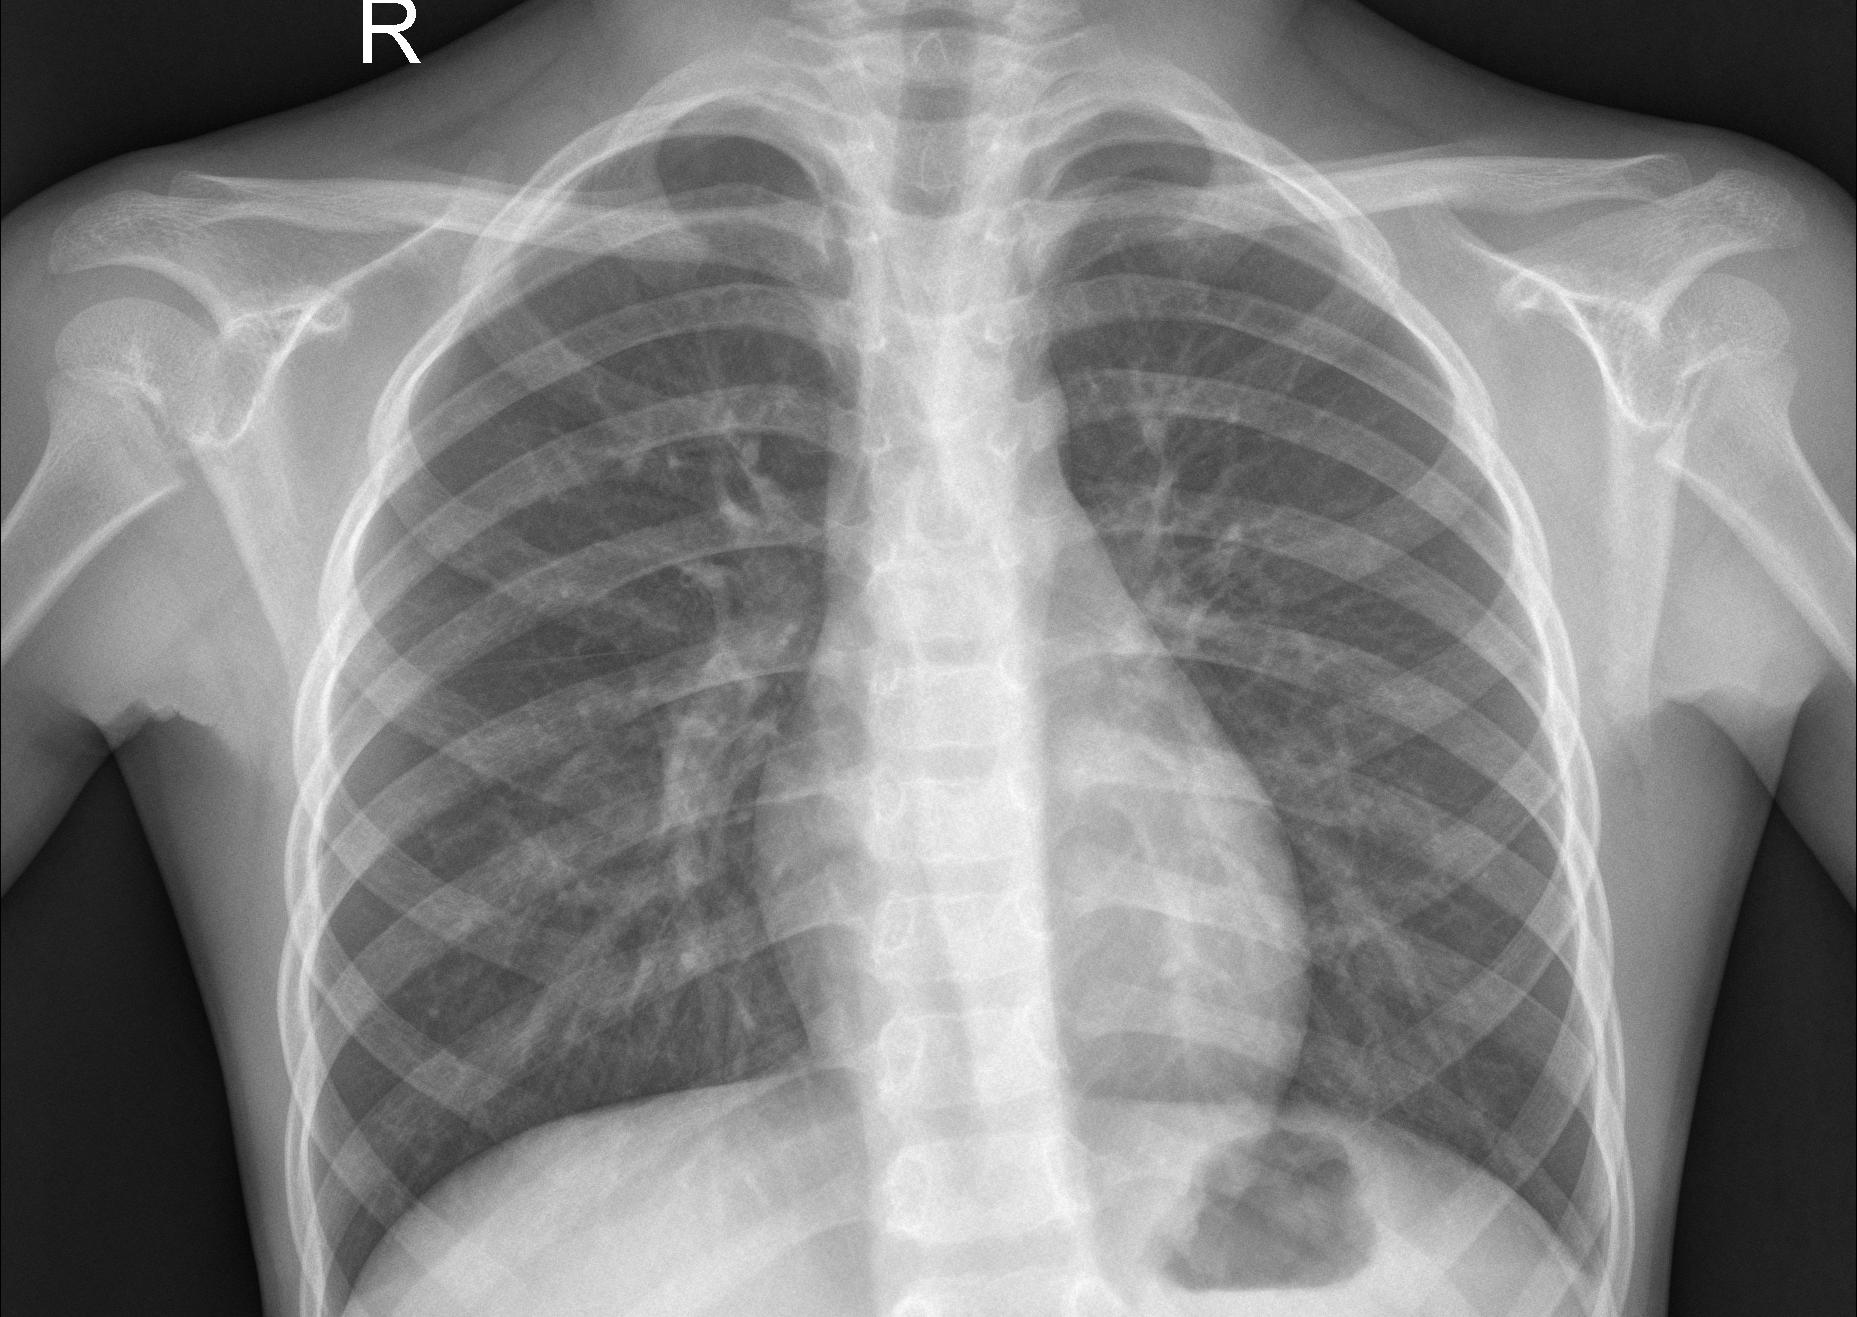

In [55]:
normal_img

In [56]:
cnn.predict(normal_img_array)

1/1 [==============================] - 0s 28ms/step


array([[0.]], dtype=float32)

In [ ]:
normal_activations = get_activations(cnn,normal_img_array)

1/1 [==============================] - ETA: 0s

In [ ]:
plot_conv_layer_result(normal_activations,0)

In [ ]:
plot_conv_layer_result(normal_activations,1)

In [ ]:
plot_conv_layer_result(normal_activations,2)

In [ ]:
plot_conv_layer_result(normal_activations,3)

In [ ]:
plot_1d_layer_result(normal_activations,4)

In [ ]:
plot_1d_layer_result(normal_activations,5)

In [ ]:
plot_1d_layer_result(normal_activations,6)